In [681]:
import cdflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from datetime import datetime
import scipy.stats as stats
import os

In [710]:
class SAT_DATA():
    def __init__(self, dir):
        
        files = os.listdir(dir)
        self.file_lis = [dir+f for f in files if os.path.isfile(os.path.join(dir, f))]

    def open(self, path):
        # print(f'OPEN {path}')
        
        cdf_file = cdflib.CDF(path)
        # イオン, エレクトロン
        self.ion = cdf_file['ION_DIFF_ENERGY_FLUX']
        self.electron = cdf_file['ELE_DIFF_ENERGY_FLUX']
        self.channel = cdf_file['CHANNEL_ENERGIES']
        # 日にち
        epoch = cdflib.cdfepoch.unixtime(cdf_file['Epoch'])
        self.date = [datetime.utcfromtimestamp(e) for e in epoch]
        # 緯度経度（地磁気座標系）
        self.lat = abs(cdf_file['SC_AACGM_LAT'])
        self.lon = cdf_file['SC_AACGM_LTIME'] * np.pi / 12
        
    # 表面帯電の概要をヒートマップで図示
    def heat_map(self, mode='I', st=67500):
        if mode == 'I':
            data = self.ion
            vmin = 1e3
            vmax = 1e8
            title = 'ION'
        elif mode == 'E':
            data = self.electron
            vmin = 1e5
            vmax = 1e10
            title = 'ELECTRON'

        et = st + 120
        df = pd.DataFrame(data.T[:, st:et], columns=self.date[st:et], index=self.channel)
        df_mask = (df == 0)
        plt.figure(figsize=(20,2))
        sns.heatmap(df, linewidths = 1, cmap = "jet", mask = df_mask, norm=LogNorm(vmin=vmin,vmax=vmax))
        plt.title(f'{title}_DIFF_ENERGY_FLUX')
        plt.xlabel('date', fontsize=15)
        plt.ylabel('energy [eV]', fontsize=15);

    # エネルギースペクトルを図示
    def plot_spectra(self, id=67520):
        plt.plot(self.channel, self.ion[id], marker='o', label='ION')
        plt.plot(self.channel, self.electron[id], marker='o', label='ELECTRON')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Energy [eV]')
        plt.ylabel('Energy Flux [ev/cm2/delta-eV/ster/s]')
        plt.grid()
        plt.legend();

    # スミルノフ･グラブス検定
    def smirnov_grubbs(self, data, alpha):
        x, o = list(data), []
        while len(x) > 2:
            n = len(x)
            t = stats.t.isf(q=(alpha / n) / 2, df=n - 2)
            tau = (n - 1) * t / np.sqrt(n * (n - 2) + n * t * t)
            i_min, i_max = np.argmin(x), np.argmax(x)
            myu, std = np.mean(x), np.std(x, ddof=1)
            i_far = i_max if np.abs(x[i_max] - myu) > np.abs(x[i_min] - myu) else i_min
            tau_far = np.abs((x[i_far] - myu) / std)
            if tau_far < tau: 
                break
            o.append(x.pop(i_far))
        return np.array(o)

    # 帯電している時間を検知
    def detect_charge(self):
        check_id_list = []
        alpha = 0.01
        charge_id = []
        for i, ele in enumerate(self.electron):
            if any(ele[:3] > 1e8):
                check_id_list.append(i)

        for i in check_id_list:
            check_ion = self.ion[i][self.ion[i] > 0]
            if len(check_ion) <= 2:
                continue
            out_array = self.smirnov_grubbs(check_ion, alpha)
            if len(out_array) > 0 and any(out_array > 1e7):
                ch = np.where(self.ion[i] == out_array.max())[0]
                charge_id.append((i, ch[0]))
        return charge_id

    # 帯電している位置を取得（地磁気座標系）
    def get_charge_pos(self):
        La = []
        Lo = []
        ind = self.detect_charge()
        for i, _ in ind:
            La.append(self.lat[i])
            Lo.append(self.lon[i])
        return La, Lo
    
    # 帯電している位置を図示
    def plot_charge_pos(self):
        La, Lo = self.get_charge_pos()
        ax = plt.subplot(111, projection="polar")
        ax.scatter(Lo, La)
        ax.set_ylim([90,40]);

In [699]:
path = 'DATA/dmsp-f16_20110502.cdf'
cdflib.cdf_to_xarray(path)

<xarray.Dataset>
Dimensions:                    (Epoch: 86400, dim0: 3, CHANNEL_ENERGIES: 19,
                                dim1: 19)
Coordinates:
  * Epoch                      (Epoch) float64 6.347e+13 6.347e+13 ... 6.347e+13
  * CHANNEL_ENERGIES           (CHANNEL_ENERGIES) float32 3e+04 ... 30.0
Dimensions without coordinates: dim0, dim1
Data variables: (12/26)
    SC_ECI                     (Epoch, dim0) float64 -273.6 ... -5.473e+03
    SC_ECI_LABEL               (dim0) <U5 'x_ECI' 'y_ECI' 'z_ECI'
    SC_GEOCENTRIC_LAT          (Epoch) float64 -80.07 -80.1 ... -49.25 -49.19
    SC_GEOCENTRIC_LON          (Epoch) float64 37.77 37.47 37.16 ... 287.8 287.8
    SC_GEOCENTRIC_R            (Epoch) float64 7.235e+03 7.235e+03 ... 7.23e+03
    SC_AACGM_LAT               (Epoch) float64 -74.23 -74.2 ... -40.65 -40.6
    ...                         ...
    ION_DIFF_ENERGY_FLUX       (Epoch, CHANNEL_ENERGIES) float32 2.868e+04 .....
    ION_DIFF_ENERGY_FLUX_STD   (Epoch, CHANNEL_ENERGIES) float32 1.118 ... nan
    ION_TOTAL_ENERGY_FLUX      (Epoch) float32 6.907e+09 6.961e+09 ... 0.0
    ION_TOTAL_ENERGY_FLUX_STD  (Epoch) float32 0.3838 0.3954 0.3604 ... 1.84 nan
    ION_AVG_ENERGY             (Epoch) float32 7.712e+03 6.878e+03 ... nan
    ION_AVG_ENERGY_STD         (Epoch) float32 0.5086 0.5146 0.5117 ... 2.66 nan
Attributes: (12/26)
    Project:                     DMSP
    Source_name:                 dmsp-f16
    Discipline:                  ['Space Physics>Magnetospheric Science', 'Sp...
    Data_type:                   precipitating-electrons-ions
    Descriptor:                  ssj
    File_naming_convention:      source_descriptor_datatype_yyyyMMdd
    ...                          ...
    MODS:                        This is version 1, beta.
    LINK_TEXT:                   NGDC Solar & Terrestrial Physics Satellite D...
    LINK_TITLE:                  NGDC STP Satellite Data Services
    HTTP_LINK:                   http://www.ngdc.noaa.gov/stp/satellite/satda...
    DWELL_TIME:                  The count integration time at each energy st...
    VERSION:                      1.1.2

In [713]:
sat = SAT_DATA('../DATA/dmsp-f16/2011/05/')
sat.open(sat.file_lis[-1])

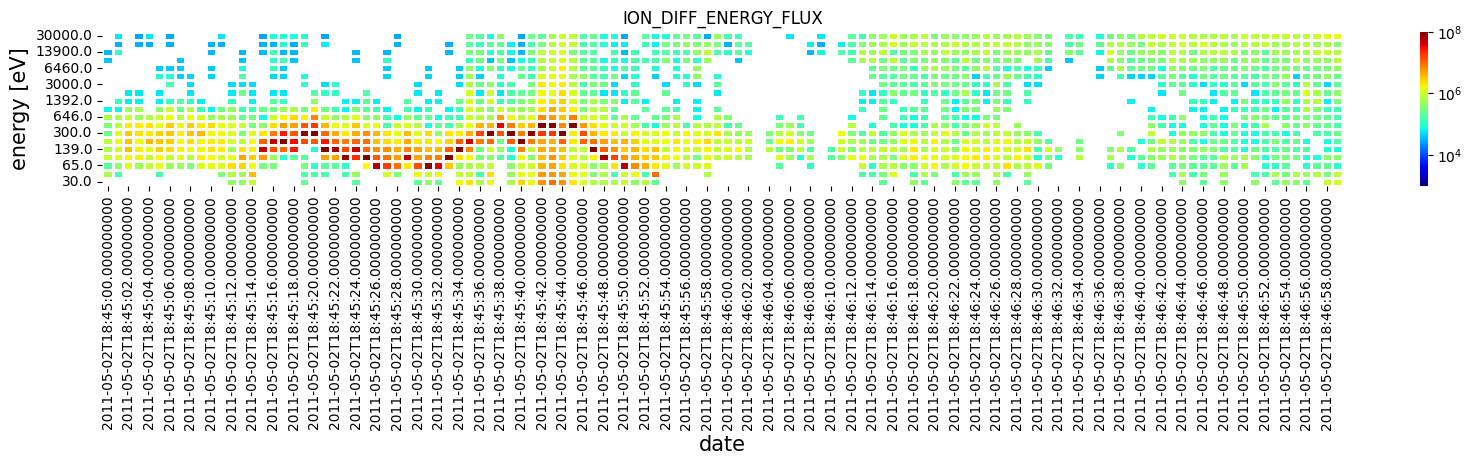

In [703]:
sat.heat_map('I')

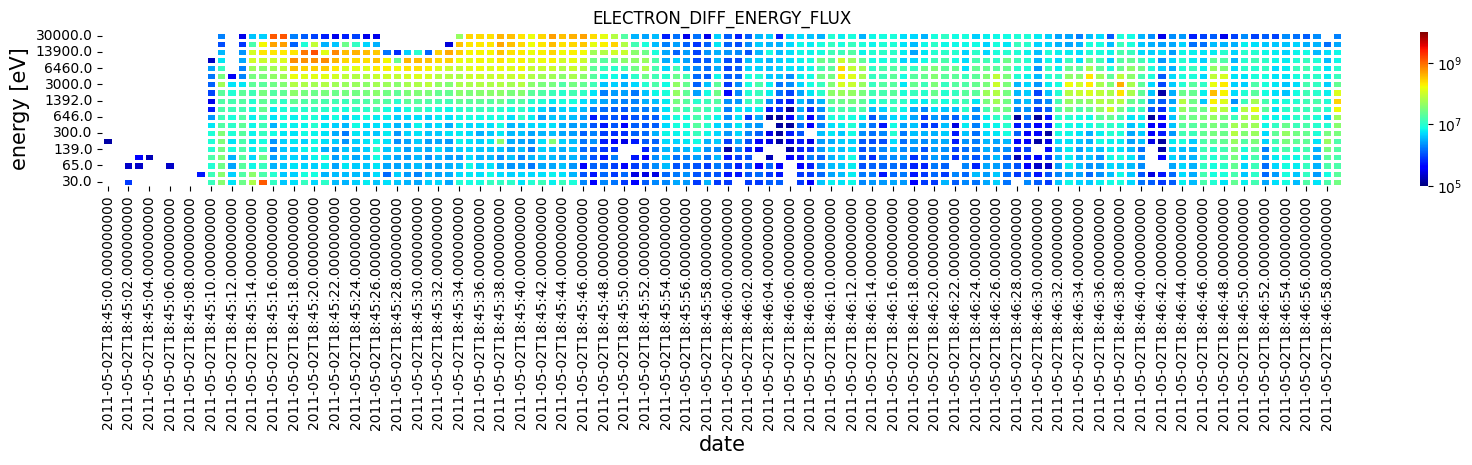

In [704]:
sat.heat_map('E')

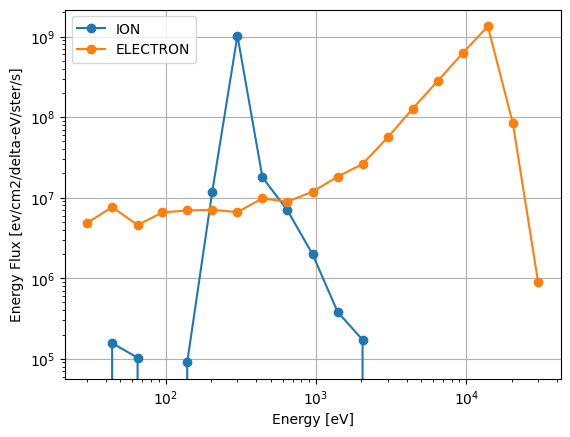

In [705]:
sat.plot_spectra()

In [706]:
ind = sat.detect_charge()

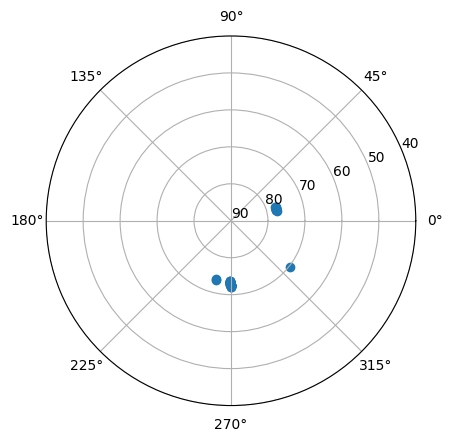

In [707]:
sat.plot_charge_pos()

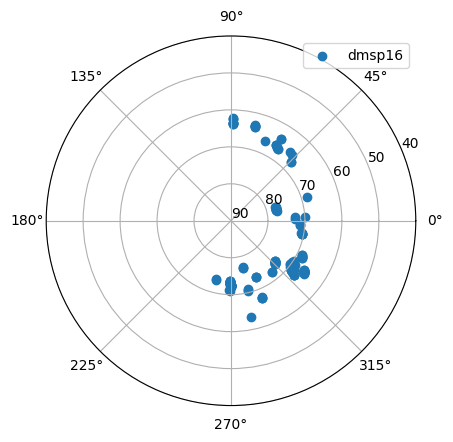

In [714]:
La = []
Lo = []
for path in sat.file_lis:
    sat.open(path)
    la, lo = sat.get_charge_pos()
    La.extend(la)
    Lo.extend(lo)

ax = plt.subplot(111, projection="polar")

ax.scatter(Lo, La, label='dmsp16')
ax.set_ylim([90, 40])
plt.legend()
plt.show()

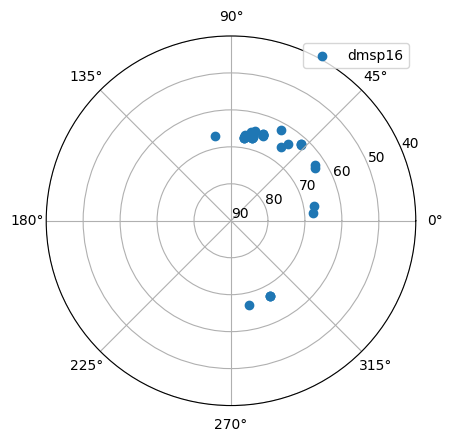

In [712]:
sat = SAT_DATA('../DATA/dmsp-f16/2014/05/')
La = []
Lo = []
for path in sat.file_lis:
    sat.open(path)
    la, lo = sat.get_charge_pos()
    La.extend(la)
    Lo.extend(lo)

ax = plt.subplot(111, projection="polar")

ax.scatter(Lo, La, label='dmsp16')
ax.set_ylim([90, 40])
plt.legend()
plt.show()